# Predict residence time based on scavenging fields

$$ \frac{\partial [dPb]}{\partial t} = - (\beta \cdot P_{litho,authigenic} + (1-\beta) \cdot P_{biogenic} ) \cdot k_{p} \cdot [dPb] $$

In [2]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import xarray as xr
import cmocean
import pickle
from matplotlib.colors import ListedColormap
import matplotlib.backends.backend_pdf

%matplotlib inline

#### Parameters:

In [3]:
# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179
jsize = jmax-jmin
isize = imax-imin

# Colors:
land_color  = '#a9a7a2'
g           = '#c1c1c1'
colors      = ['#b3cde0','#005b96','#b5754c','#dbd3ce','#c36f79','#a2444f']

#### Load files:

In [4]:
# Modified ANHA12 mesh mask file (http://knossos.eas.ualberta.ca/anha/anhatable.php)
mfile    = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20230213.nc')
mesh_lon = mfile['nav_lon'].values
mesh_lat = mfile['nav_lat'].values
mask     = mfile['tmask'].values[0]
mesh_bathy   = mfile['tmask'].values[0,:,:,:]
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
mesh_depth   = mfile['nav_lev'].values
mesh_dz      = np.diff(mesh_depth, prepend=0)

# Modified ANHA12 mesh mask file (http://knossos.eas.ualberta.ca/anha/anhatable.php)
mesh  = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
hdept = mesh['hdept'].values[0,:,:]

Load particle fields

In [5]:
# BLING:
folder_EPM101 = '/data/brogalla/ANHA4/BLING-EPM151/'
dset          = xr.open_dataset(f'/data/brogalla/ANHA4/BLING-EPM151/ANHA4-EPM151_y2002m08d13_gridB.nc')
ANHA4_lons    = dset['nav_lon'].values
ANHA4_lats    = dset['nav_lat'].values
ANHA4_depths  = dset['deptht'].values
BLING_fpop    = dset['fpop'].values
BLING_biomass = dset['biomass_p'].values

# Mn for surface particle field:
dset_ANHA12 = xr.open_dataset('/data/brogalla/run_storage/Mn-extended-domain-202210/oMn_y2002m01.nc')
ANHA12_lons = mesh_lon[imin:imax,jmin:jmax]
ANHA12_lats = mesh_lat[imin:imax,jmin:jmax]

# Forcing fields:
year  = 2002
oMn   = np.zeros((12,len(mesh_depth),isize,jsize)); fpop  = np.zeros((12,len(mesh_depth),isize,jsize));
fpops = np.zeros((12,len(mesh_depth),isize,jsize)); biom  = np.zeros((12,len(mesh_depth),isize,jsize));
for month in range(1,13):
    df = xr.open_dataset(f'/ocean/brogalla/GEOTRACES/data/Pb-forcing-202311/particle-fields/Pb_scavenging_y{year}m{month:02}.nc')
    oMn[month-1,:,:,:]   = df['oxidisMn'].values[:,:,:]
    fpop[month-1,:,:,:]  = df['fpop'].values[:,:,:]
    fpops[month-1,:,:,:] = df['fpop-sink'].values[:,:,:]
    biom[month-1,:,:,:]  = df['biomass'].values[:,:,:]

In [7]:
Pbio = BLING_fpop[0,:,:,:] + BLING_biomass[0,:,:,:]

In [8]:
norm1 = Pbio[0,::5,::5]/np.nanmax(Pbio)
norm2 = (Pbio[0,::5,::5]/np.nanmax(Pbio))*np.nanmax(Pbio)**0.15

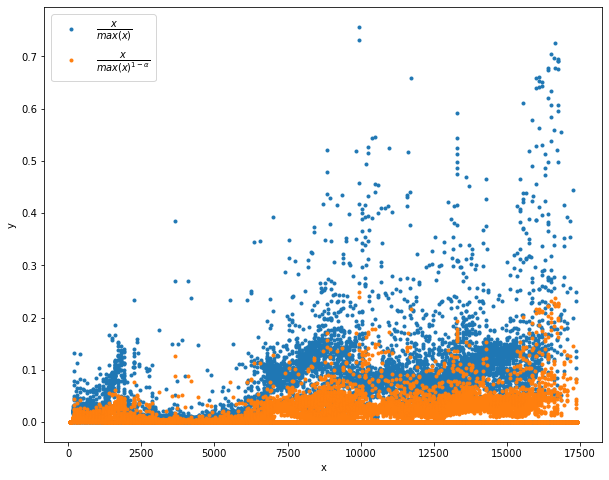

In [9]:
fig, ax = plt.subplots(1,1,figsize=(10,8))

plt.plot(norm1.flatten(), '.', label=r'$\frac{x}{max(x)}$')
plt.plot(norm2.flatten(), '.', label=r'$\frac{x}{max(x)^{1-\alpha}}$')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(fontsize=14)

Create mask for different regions to create average profiles over:

In [6]:
# Average basin profiles for different regions 
# --- Canada Basin ---
CB_mask  = np.zeros(bathy_masked.shape)
CB_mask[:,imin+10:imax-10,jmin+10:jmax-20] = 1 # excluding the regions of boundary conditions
for depth in range(0,50):
    CB_mask[depth][mesh_lon > -80]   = 0
    CB_mask[depth][hdept < 2000]     = 0

CB_mask[mesh_bathy < 0.1] = 0

# --- CAA ---
CAA_mask = np.zeros(bathy_masked.shape)
CAA_mask[:,imin+10:imax-10,jmin+10:jmax-20] = 1 # excluding the regions of boundary conditions
for depth in range(0,50):
    CAA_mask[depth][hdept > 500]     = 0
    CAA_mask[depth][mesh_lon < -130] = 0
    CAA_mask[depth][mesh_lon > -40]  = 0
    CAA_mask[depth][mesh_lat < 65]   = 0
    CAA_mask[depth][(mesh_lat < 75) & (mesh_lon >-75)] = 0
    
CAA_mask[mesh_bathy < 0.1] = 0

# --- Baffin Bay ---
BB_mask  = np.zeros(bathy_masked.shape)
BB_mask[:,imin+10:imax-10,jmin+10:jmax-20] = 1 # excluding the regions of boundary conditions
for depth in range(0,50):
    BB_mask[depth][mesh_lon < -75]   = 0
    BB_mask[depth][hdept < 1000]     = 0
    BB_mask[depth][mesh_lat <= 65]   = 0
    BB_mask[depth][mesh_lat > 80]    = 0

BB_mask[mesh_bathy < 0.1] = 0
    
# --- Labrador Sea ---
LS_mask  = np.zeros(bathy_masked.shape)
LS_mask[:,imin+10:imax-10,jmin+10:jmax-20] = 1 # excluding the regions of boundary conditions
for depth in range(0,50):
    LS_mask[depth][mesh_lon < -75]   = 0
    LS_mask[depth][mesh_lat > 65]    = 0
    LS_mask[depth][hdept < 2000]     = 0
    
LS_mask[mesh_bathy < 0.1] = 0

#### Functions

In [7]:
def calc_regional_profile(variable):
    # Function to calculate mean profiles of residence time for each of the 4 regions
    
    # Separate based on region:
    CB_variable  = np.ma.masked_where(CB_mask[:,imin:imax,jmin:jmax]!=1 , variable)
    CAA_variable = np.ma.masked_where(CAA_mask[:,imin:imax,jmin:jmax]!=1, variable)
    BB_variable  = np.ma.masked_where(BB_mask[:,imin:imax,jmin:jmax]!=1 , variable)
    LS_variable  = np.ma.masked_where(LS_mask[:,imin:imax,jmin:jmax]!=1 , variable)
    
    # and mask land:
    CB_variable  = np.ma.masked_where((mesh_bathy[:,imin:imax,jmin:jmax] < 0.1), CB_variable)
    CAA_variable = np.ma.masked_where((mesh_bathy[:,imin:imax,jmin:jmax] < 0.1), CAA_variable)
    BB_variable  = np.ma.masked_where((mesh_bathy[:,imin:imax,jmin:jmax] < 0.1), BB_variable)
    LS_variable  = np.ma.masked_where((mesh_bathy[:,imin:imax,jmin:jmax] < 0.1), LS_variable)

    # Calculate mean over each of the regions:
    CB_mean_var    = np.ma.mean(CB_variable , axis=(1,2))
    CAA_mean_var   = np.ma.mean(CAA_variable, axis=(1,2))
    BB_mean_var    = np.ma.mean(BB_variable , axis=(1,2))
    LS_mean_var    = np.ma.mean(LS_variable , axis=(1,2))

    return CB_mean_var.filled(fill_value=np.nan), CAA_mean_var.filled(fill_value=np.nan), \
                BB_mean_var.filled(fill_value=np.nan), LS_mean_var.filled(fill_value=np.nan)

In [8]:
def plot_regional(ax, tau, title, legend=False):
    
    ax.plot(tau[0][0], mesh_depth, label='CB', linewidth=0.8)
    ax.plot(tau[0][1], mesh_depth, label='CAA', linewidth=0.8)
    ax.plot(tau[0][2], mesh_depth, label='BB', linewidth=0.8)
    ax.plot(tau[0][3], mesh_depth, label='LS', linewidth=0.8)
    
    # Manually set the position and relative size of the inset axes within ax1    
    ax.tick_params(labelsize=6, pad=0)
    ax.xaxis.tick_top()    
    ax.xaxis.set_label_position('top') 
    
    if legend:
        ax.legend(loc=(-0.35, 0.98), fontsize=6, frameon=False)
        
    ax.set_title(title, fontsize=7)
    return

In [9]:
def plot_regional_tau(tau, keys=['','','','']):
    
    fig, ax = plt.subplots(1, 4, figsize=(8,3), dpi=300)

    fig.suptitle(f'p = {keys[0].split("-b")[0][1:]}', fontsize=7, fontweight='bold')

    for i, axis in enumerate(ax.ravel()):
        axis.set_ylim(2500,0);
        axis.set_xlim(0,np.nanmax(tau[f'{keys[i]}'][0][0]));
        axis.set_xlabel('Residence time (years)', fontsize=6)

    ax[0].set_ylabel('Depth [m]', fontsize=6)
    plot_regional(ax[0], tau[f'{keys[0]}'], f'beta={keys[0].split("-b")[1]}', legend=True)
    plot_regional(ax[1], tau[f'{keys[1]}'], f'beta={keys[1].split("-b")[1]}')
    plot_regional(ax[2], tau[f'{keys[2]}'], f'beta={keys[2].split("-b")[1]}')
    plot_regional(ax[3], tau[f'{keys[3]}'], f'beta={keys[3].split("-b")[1]}')

    left, bottom, width, height = [0.11, 0.1, 0.06, 0.23]
    ax1 = fig.add_axes([left, bottom, width, height]);
    ax2 = fig.add_axes([left*3.2, bottom, width, height]);
    ax3 = fig.add_axes([left*5.4, bottom, width, height]);
    ax4 = fig.add_axes([left*7.5, bottom, width, height]); 
    plot_regional(ax1, tau[f'{keys[0]}'], '')
    plot_regional(ax2, tau[f'{keys[1]}'], '')
    plot_regional(ax3, tau[f'{keys[2]}'], '')
    plot_regional(ax4, tau[f'{keys[3]}'], '')

    for i,axis in enumerate([ax1,ax2,ax3,ax4]):
        axis.set_ylim(60,0);     
        axis.set_xlim(0,5)
        axis.locator_params(axis='x', nbins=6)
        axis.tick_params(labelsize=5, pad=0)
        for label in axis.get_xticklabels()[::2]:
            label.set_visible(False)
    
    plt.tight_layout()
    return fig

In [10]:
def calc_residence_time_kscav(part_scav, k=1, regional=False):
    
    scav_total = np.nansum(k*part_scav, axis=0)   
    
    # mask zero values:
    scav_totalm = np.ma.masked_where(scav_total <= 0, scav_total/12)
    
    # Convert residence time from seconds to years:
    residence_time = 1 / (scav_totalm*3600*24*365)
    
    if regional:
        return [calc_regional_profile(residence_time)]
    else:
        return residence_time

In [11]:
def calc_kscav(oMn, fpop, fpops, biom, oMn_max=np.nan, bio_max=np.nan,
               ln_fpop=False, ln_fpop_sink=True, ln_biomass=True, beta=0.005, power=1):
    # beta --- fraction lithogenic
    
    litho_particles_norm = oMn[:,:,:,:]/oMn_max
    bio_particles        = ln_fpop*fpop[:,:,:,:] + ln_fpop_sink*fpops[:,:,:,:] + ln_biomass*biom[:,:,:,:]
    
    bio_particles_norm   = bio_particles/(bio_max**(1-power))
    bio_particles_norm[bio_particles_norm < 0] = 0
    
    particles            = litho_particles_norm*beta + (1-beta)*(bio_particles_norm)
    part_scav            = particles
    return particles

In [12]:
def main_calc(year, bio_max=np.nan, oMn_max=np.nan, ln_fpop=False, ln_fpop_sink=True, ln_biomass=True):
    
    oMn   = np.zeros((12,len(mesh_depth),isize,jsize)); fpop  = np.zeros((12,len(mesh_depth),isize,jsize));
    fpops = np.zeros((12,len(mesh_depth),isize,jsize)); biom  = np.zeros((12,len(mesh_depth),isize,jsize));
    for month in range(1,13):
        df = xr.open_dataset(f'/ocean/brogalla/GEOTRACES/data/Pb-forcing-202311/particle-fields/Pb_scavenging_y{year}m{month:02}.nc')
        oMn[month-1,:,:,:]   = df['oxidisMn'].values[:,:,:]
        fpop[month-1,:,:,:]  = df['fpop'].values[:,:,:]
        fpops[month-1,:,:,:] = df['fpop-sink'].values[:,:,:]
        biom[month-1,:,:,:]  = df['biomass'].values[:,:,:]
        
    particles = calc_kscav(oMn, fpop, fpops, biom, bio_max=bio_max, oMn_max=oMn_max, beta=0.10, power=0.15)
    
    return particles

In [13]:
def save_file(folder, particle_array, year, month):   
    
    file_write = xr.Dataset(
        {'particles' : (("deptht","y","x"), particle_array)},
        coords = {
            "time_counter": np.zeros(1),
            "deptht": mesh_depth,
            "y": np.zeros(mesh_lat.shape[0]),
            "x": np.zeros(mesh_lon.shape[1])},
    )
    file_write.to_netcdf(f'{folder}Pb_scavenging_y{year}m{month:02}.nc', \
                         unlimited_dims='time_counter')

    return

In [14]:
def calc_max(year, ln_fpop=False, ln_fpop_sink=True, ln_biomass=True):
    
    oMn   = np.zeros((12,len(mesh_depth),isize,jsize)); fpop  = np.zeros((12,len(mesh_depth),isize,jsize));
    fpops = np.zeros((12,len(mesh_depth),isize,jsize)); biom  = np.zeros((12,len(mesh_depth),isize,jsize));
    for month in range(1,13):
        df = xr.open_dataset(f'/ocean/brogalla/GEOTRACES/data/Pb-forcing-202311/particle-fields/Pb_scavenging_y{year}m{month:02}.nc')
        oMn[month-1,:,:,:]   = df['oxidisMn'].values[:,:,:]
        fpop[month-1,:,:,:]  = df['fpop'].values[:,:,:]
        fpops[month-1,:,:,:] = df['fpop-sink'].values[:,:,:]
        biom[month-1,:,:,:]  = df['biomass'].values[:,:,:]

    litho_max = np.nanmax(oMn[:,:,:,:])    
    bio_max   = np.nanmax(ln_fpop*fpop[:,:,:,:] + ln_fpop_sink*fpops[:,:,:,:] + ln_biomass*biom[:,:,:,:])
    
    return litho_max, bio_max

#### Create files

In [24]:
# find maximum values for biogenic and lithogenic particle fields:
litho_max = np.zeros(len(range(2002,2022)))
bio_max   = np.zeros(len(range(2002,2022)))
for ind, year in enumerate(range(2002,2022)):
    print(year)
    litho_max[ind], bio_max[ind] = calc_max(year)

2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


In [25]:
print(np.max(litho_max), litho_max)
print(np.max(bio_max), bio_max)
# 1.8331377305003116e-07 [1.63297997e-07 1.42925288e-07 1.49482332e-07 1.21099518e-07
#  1.29992230e-07 1.39673574e-07 1.37485657e-07 1.60435633e-07
#  1.83313773e-07 1.61249687e-07 1.42295363e-07 1.52282340e-07
#  1.65701664e-07 1.54501535e-07 1.56535179e-07 1.53486738e-07
#  1.49739236e-07]
# 0.000702514880686067 [0.00063219 0.00058158 0.00068591 0.00063547 0.00061144 0.00062436
#  0.00065174 0.00063359 0.00063696 0.00066724 0.00070251 0.00064366
#  0.00063303 0.00063147 0.00063866 0.         0.        ]

1.8331377305003116e-07 [1.63297997e-07 1.42925288e-07 1.49482332e-07 1.21099518e-07
 1.29992230e-07 1.39673574e-07 1.37485657e-07 1.60435633e-07
 1.83313773e-07 1.61249687e-07 1.42295363e-07 1.52282340e-07
 1.65701664e-07 1.54501535e-07 1.56535179e-07 1.53486738e-07
 1.49739236e-07 1.48354985e-07 1.25047791e-07 1.60055478e-07]
0.0007471436147170607 [0.00064708 0.00058133 0.00071798 0.00074714 0.00061171 0.00066749
 0.00063228 0.00066351 0.00067924 0.00070375 0.00072508 0.00064383
 0.00064291 0.00065073 0.00066608 0.0007009  0.00070039 0.00068457
 0.00066491 0.00065808]


In [15]:
folder = '/ocean/brogalla/GEOTRACES/data/Pb-forcing-202311/scavenging/'
for year in range(2018,2022):
    particles                          = np.zeros((12,) + mesh_bathy.shape)
    particles[:,:,imin:imax,jmin:jmax] = main_calc(year, bio_max=7.47144e-4, oMn_max=1.83314e-07)
    print(year, np.amax(particles[:,:,imin:imax,jmin:jmax]), np.amin(particles[:,:,imin:imax,jmin:jmax]), \
          np.mean(particles[:,:,imin:imax,jmin:jmax]))
    for month in range(1,13): 
#         print(year, month)
        save_file(f'{folder}', particles[month-1,:,:,:], year, month)

2018 0.2868609518803102 0.0 0.001642211600110244
2019 0.2801735601488317 0.0 0.0016758379503918994
2020 0.272320292028421 0.0 0.0016620849233360262
2021 0.26962289694534575 0.0 0.001661539307669339


#### Estimations

In [15]:
power_exps = [0.15] #[0.15, 0.25, 0.5, 1.0]
betas      = [0.05, 0.10, 0.20, 0.30] #[0.005, 0.01, 0.05, 0.10]

kscav     = {}
tau       = {}
for p in power_exps:    
    for b in betas:
        kscav[f'p{p}-b{b}'] = calc_kscav(oMn, fpop, fpops, biom, beta=b, power=p, bio_max=7.02515e-4, oMn_max=1.83314e-07)
        tau[f'p{p}-b{b}']   = calc_residence_time_kscav(kscav[f'p{p}-b{b}'], k=5e-6, regional=True)

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


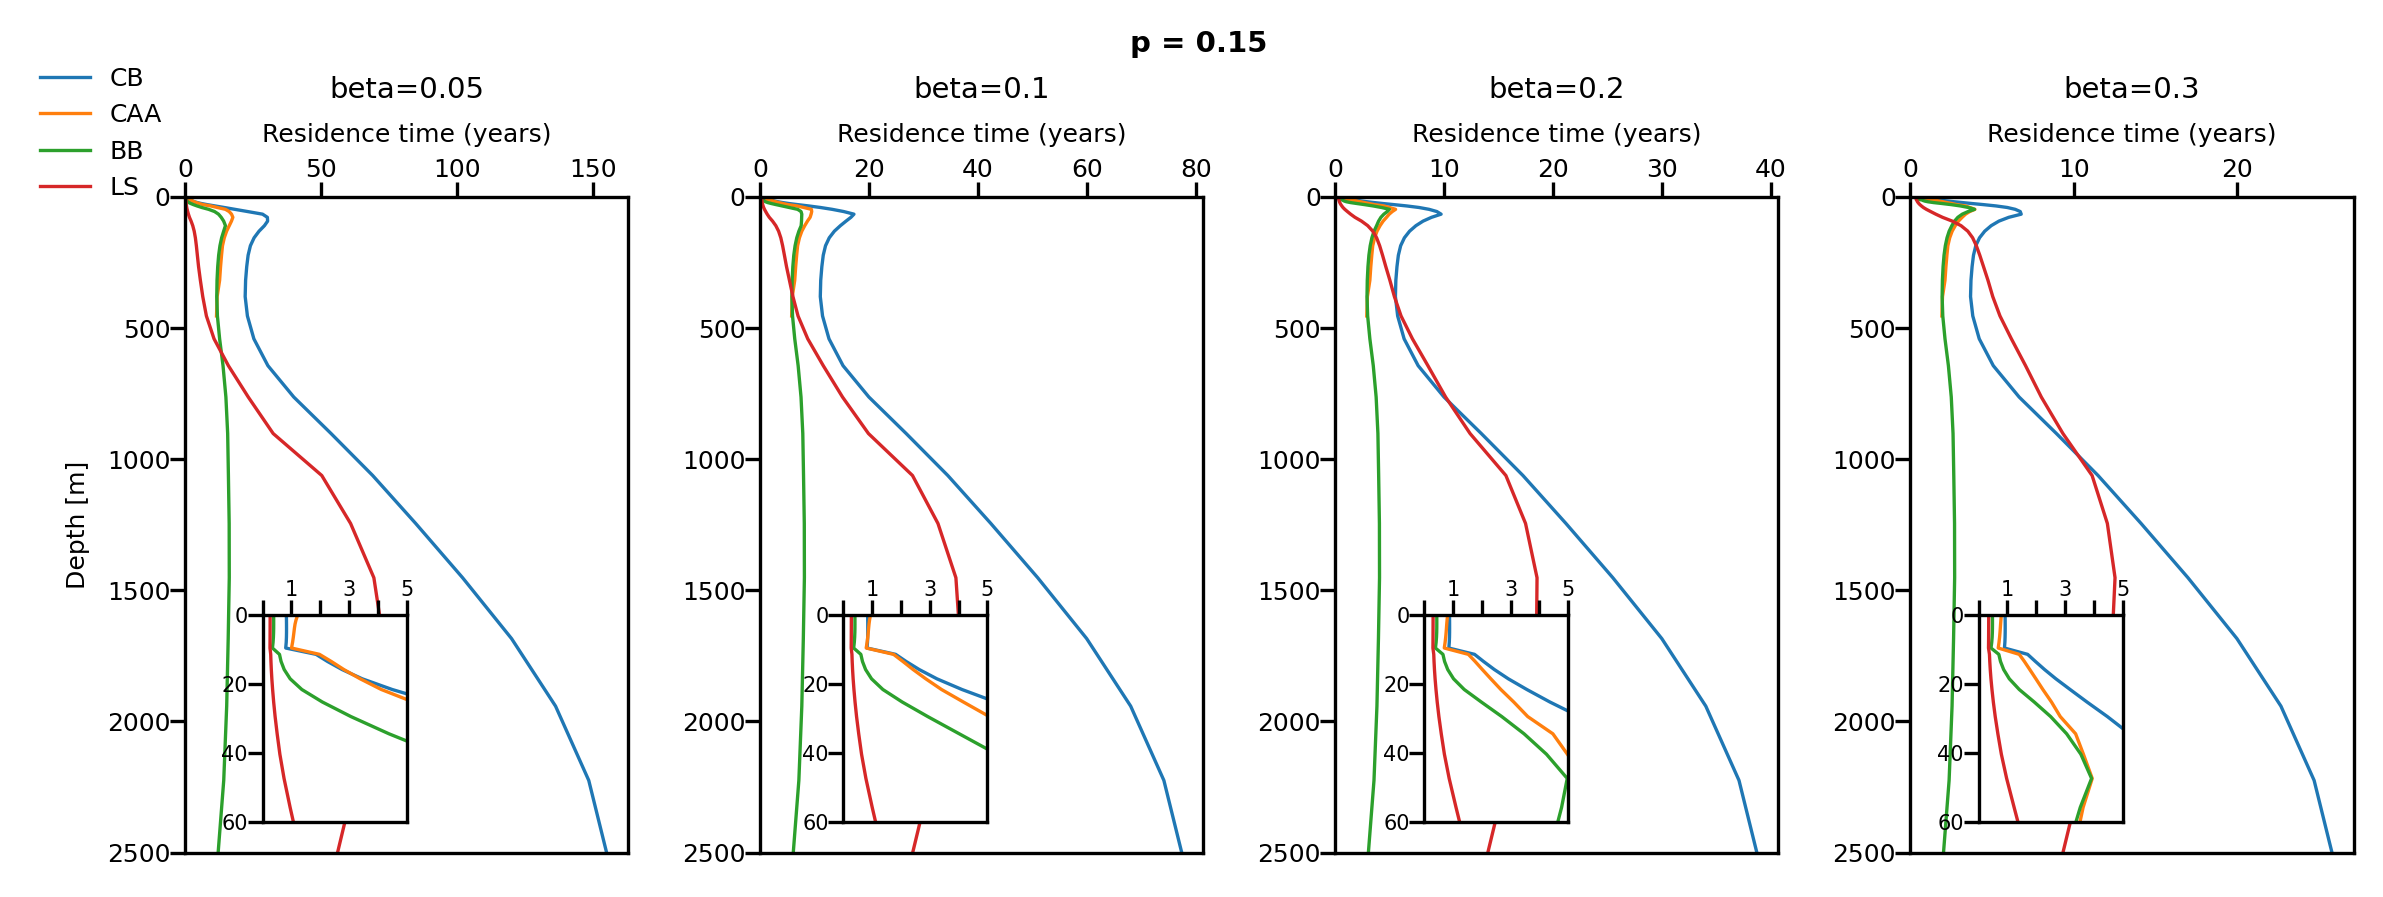

In [16]:
# With new version of method (normalized by 1-alpha power)
fig = {}
for power in power_exps:
    fig[f'p{power}'] = plot_regional_tau(tau, keys=[f'p{power}-b{betas[0]}',f'p{power}-b{betas[1]}',
                                                    f'p{power}-b{betas[2]}',f'p{power}-b{betas[3]}'])    